# Load libraries

In [1]:
#Note: This notebook was run in the conda environment named "Jacob_Env1" (provided on GitHub)

In [2]:
#You are currently looking at the notebook processing/plotting keratinocytes only
cell_type = 'Epi'

In [3]:
#Load the required packages
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import pandas as pd
import numpy as np
import sys
import seaborn as sbn
import scanpy as sc
import scvelo as scv
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import bbknn
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator
import cellrank as cr
from cellrank.tl.kernels import VelocityKernel
from cellrank.tl.kernels import ConnectivityKernel
from cellrank.tl.kernels import PalantirKernel
from cellrank.tl.estimators import GPCCA

In [4]:
#Set paths
path = '/mnt/c/Users/User/Jacob-Et-Al'

In [5]:
#Load gene list required for cell cycle scoring
cell_cycle_genes_path = os.path.join(path,'Notebook-Input','regev_lab_cell_cycle_genes.txt')
cell_cycle_genes = [x.strip().title() for x in open(cell_cycle_genes_path)]

# Separate dataset for S-phase or G2M-phase associated genes
s_genes = [x for x in cell_cycle_genes[:43]]
g2m_genes = [x for x in cell_cycle_genes[43:]]

In [6]:
scv.logging.print_version()
sc.logging.print_header()
cr.logging.print_versions()

Running scvelo 0.2.2 (python 3.7.7) on 2023-04-06 12:55.
scanpy==1.4.6 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.1 scikit-learn==0.23.2 statsmodels==0.12.0rc0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.0
cellrank==1.1.0 scanpy==1.4.6 anndata==0.7.4 numpy==1.19.1 numba==0.51.0 scipy==1.5.2 pandas==1.1.1 scikit-learn==0.23.2 statsmodels==0.12.0rc0 python-igraph==0.7.1 scvelo==0.2.2 pygam==0.8.0 matplotlib==3.3.2 seaborn==0.10.1


In [7]:
#Define function that can remove axis elements from subplots
#axes can be either an individual subplot, a list of individual subplots or mix of multiple subplots in a nested list.
def clean_axis(axes, remove_borders = True, remove_ticks = True, remove_axis_labels = True):
    axes = flatten_list(axes)
    print(axes)
    for ax in axes:
        if remove_borders:
            for loc in ['left','right','top','bottom']:
                ax.spines[loc].set_visible(False)
        if remove_ticks:
            for side in ['x','y']:
                ax.tick_params(
                    axis=side,  # changes apply to the x-axis
                    which='both',  # both major and minor ticks are affected
                    bottom=False,  # ticks along the bottom edge are off
                    top=False,  # ticks along the top edge are off
                    left=False,
                    labelbottom=False,
                    labelleft=False,
                    labeltop = False)
        if remove_axis_labels:
            ax.set_ylabel('')
            ax.set_xlabel('')

#Define function to generate a plot with multiple subplots
def initialize_subplots(groups_to_plot, ncols = 3, figsize_multiplier = (7,5), gridspec_kw = None, figsize = None, print_help = True, **fig_kw):
    if type(groups_to_plot)==list:
        total = len(groups_to_plot)
    else:
        total = groups_to_plot
    nrows = int(np.ceil(total/ncols))
    if not figsize:
        figsize = (figsize_multiplier[0]*ncols, figsize_multiplier[1]*nrows)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize, gridspec_kw = gridspec_kw, **fig_kw)
    if print_help:
        if nrows>1 and ncols>1:
            print('ax = axes[ix // ncols, ix % ncols]')
        else:
            print('ax = axes[ix]')
    return fig, axes

# Import data

In [8]:
#Import scaled expression data which was generated with Seurat in R
adata = sc.read_csv(os.path.join(path, 'Notebook-Input','{}_ScaledData.csv'.format(cell_type))).transpose()

In [9]:
adata

AnnData object with n_obs × n_vars = 1584 × 20001

## Import metadata

In [10]:
#Import additional metadata (preprocessing was done with Seurat in R)
metadata = pd.read_csv(os.path.join(path, 'Notebook-Input', '{}_MetaData.csv'.format(cell_type)), index_col = 0)
HVGs = pd.read_csv(os.path.join(path, 'Notebook-Input', '{}_ListHVG.csv'.format(cell_type)), sep = ';', index_col = 0) 
umap = pd.read_csv(os.path.join(path, 'Notebook-Input', '{}_UMAP_Coordinates.csv'.format(cell_type)), index_col = 0)
tsne = pd.read_csv(os.path.join(path, 'Notebook-Input', '{}_TSNE_Coordinates.csv'.format(cell_type)), index_col = 0)

## Assign metadata and remove doublets

In [11]:
#Add metadata to Scanpy's adata object
adata.obs = metadata.loc[adata.obs_names]

In [12]:
#Reuse highly variable genes which were determined with Seurat in R
adata.var['highly_variable'] = [True if x in HVGs.index else False for x in adata.var_names]

In [13]:
# Change all 'HC' columns (hierarchical clustering) to categorical for better plotting results
for col in [x for x in adata.obs.columns if 'HC' in x]:
    adata.obs[col] = adata.obs[col].astype('category')

In [14]:
#Original adata object has 1584 cells and 20001 genes
adata

AnnData object with n_obs × n_vars = 1584 × 20001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'simp_index', 'invsimp_index', 'shan_index', 'perc_rpl', 'perc_rps', 'perc_hb.ab.', 'perc_mito', 'perc_hba', 'perc_hbb', 'perc_hist', 'filtered', 'sample_id', 'embryonic_age', 'genotype', 'dataset', 'sample_no', 'sample_code', 'sample_date', 'library', 'sequencing', 'sex', 'S.Score', 'G2M.Score', 'Phase', 'G1.Score', 'CC.Diff', 'HC_1', 'HC_2', 'HC_3', 'HC_4', 'HC_5', 'HC_6', 'HC_7', 'HC_8', 'HC_9', 'HC_10', 'HC_11', 'HC_12', 'HC_13', 'HC_14', 'HC_15', 'HC_16', 'HC_17', 'HC_18', 'HC_19', 'HC_20', 'HC_21', 'HC_22', 'HC_23', 'HC_24', 'HC_25', 'HC_26', 'HC_27', 'HC_28', 'HC_30', 'HC_31', 'HC_33', 'HC_35', 'HC_37', 'HC_39', 'HC_42', 'HC_45', 'HC_49', 'HC_53', 'HC_58', 'HC_64', 'HC_72', 'HC_82', 'HC_95', 'HC_112', 'HC_138', 'HC_180', 'HC_32', 'HC_41', 'HC_40'
    var: 'highly_variable'

## Correct gene names from old to approved version (scaled data)

In [15]:
symbol_names = pd.read_csv(os.path.join(path, 'Notebook-Input','Hgnc-symbol-check.csv'), header = 1, index_col = 0)['Approved symbol'].dropna()
symbol_names.loc[symbol_names.index[symbol_names.index.duplicated()]]

Input
Lnp         NUSAP1
Lnp           LNPK
Csrp2bp      KAT14
Csrp2bp     PET117
Agpat9      LPCAT1
Agpat9       GPAT3
Stra13       CENPX
Stra13     BHLHE40
PISD          PISD
PISD          SFI1
Name: Approved symbol, dtype: object

In [16]:
# Some genes had multiple corresponding new approved names in HUGO,thu we decided to remove the duplicated genes from adata
duplicated_genes = symbol_names.index[symbol_names.index.duplicated()]
adata = adata[:, [x for x in adata.var_names if x not in duplicated_genes]].copy()

In [17]:
# The number of total genes reduced from 20001 to 19996
adata

AnnData object with n_obs × n_vars = 1584 × 19996
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'simp_index', 'invsimp_index', 'shan_index', 'perc_rpl', 'perc_rps', 'perc_hb.ab.', 'perc_mito', 'perc_hba', 'perc_hbb', 'perc_hist', 'filtered', 'sample_id', 'embryonic_age', 'genotype', 'dataset', 'sample_no', 'sample_code', 'sample_date', 'library', 'sequencing', 'sex', 'S.Score', 'G2M.Score', 'Phase', 'G1.Score', 'CC.Diff', 'HC_1', 'HC_2', 'HC_3', 'HC_4', 'HC_5', 'HC_6', 'HC_7', 'HC_8', 'HC_9', 'HC_10', 'HC_11', 'HC_12', 'HC_13', 'HC_14', 'HC_15', 'HC_16', 'HC_17', 'HC_18', 'HC_19', 'HC_20', 'HC_21', 'HC_22', 'HC_23', 'HC_24', 'HC_25', 'HC_26', 'HC_27', 'HC_28', 'HC_30', 'HC_31', 'HC_33', 'HC_35', 'HC_37', 'HC_39', 'HC_42', 'HC_45', 'HC_49', 'HC_53', 'HC_58', 'HC_64', 'HC_72', 'HC_82', 'HC_95', 'HC_112', 'HC_138', 'HC_180', 'HC_32', 'HC_41', 'HC_40'
    var: 'highly_variable'

In [18]:
# Replace gene names with the approved symbols
adata.var_names = [symbol_names.loc[x].capitalize() if x in symbol_names.index else x for x in adata.var_names]

In [19]:
#After renaming one gene name was not unique anymore ('Ric8b'; old name 'Ric8'). The gene was removed.
adata.var_names[adata.var.index.duplicated()]
adata = adata[:, [True if x!='Ric8b' else False for x in adata.var_names]].copy()

## Assign names to epidermal subclusters

In [20]:
#Note: We decided to work with the clustering HC_10. However additional hierarchical clustering results (run with different resolutions) can be accessed via adata.obs
naming_dict = {3:'EPI Basal1',5:'EPI Basal2',7:'EPI Basal3',6:'EPI Basal4',2:'EPI BasalTagln',10:'EPI EarlyPlacode',8:'EPI LatePlacode',9:'EPI EarlyDiff',4:'EPI LateDiff',1:'EPI Periderm'}
adata.obs['HC_named'] = [naming_dict[x] for x in adata.obs['HC_10']]
adata.obs['HC_named'] = adata.obs['HC_named'].astype('category')

In [21]:
adata.obs['HC_named'].cat.categories

Index(['EPI Basal1', 'EPI Basal2', 'EPI Basal3', 'EPI Basal4',
       'EPI BasalTagln', 'EPI EarlyDiff', 'EPI EarlyPlacode', 'EPI LateDiff',
       'EPI LatePlacode', 'EPI Periderm'],
      dtype='object')

In [22]:
adata.uns['HC_named_colors'] = ['#ADEBEB','#248F24','#D8D041','#47D147','#29A3A3','#0047B3','#FF8c1A','#B3D1Ff','#FF6666','#1A75FF']

## Import spliced and unspliced reads

In [23]:
#Add information on spliced and unspliced reads from loom file (generated from original sequencing data)
velo_data = scv.read_loom(os.path.join(path, 'Notebook-Input', 'Jacob_Loom-File_All-Cells.loom'))

# Read in raw and normalized data to add to layers

In [24]:
raw_data = sc.read_csv(os.path.join(path, 'Notebook-Input','{}_RawData.csv'.format(cell_type))).transpose()
norm_data = sc.read_csv(os.path.join(path, 'Notebook-Input','{}_NormalizedData.csv'.format(cell_type))).transpose()

In [25]:
raw_data

AnnData object with n_obs × n_vars = 1584 × 20001

## Correct gene names from old to approved version

In [26]:
raw_data = raw_data[:, [x for x in raw_data.var_names if x not in duplicated_genes]].copy()
norm_data = norm_data[:, [x for x in norm_data.var_names if x not in duplicated_genes]].copy()

In [27]:
# Replace gene names with the approved symbols
raw_data.var_names = [symbol_names.loc[x].capitalize() if x in symbol_names.index else x for x in raw_data.var_names]
norm_data.var_names = [symbol_names.loc[x].capitalize() if x in symbol_names.index else x for x in norm_data.var_names]

In [28]:
# Remove 'Ric8b' gene from adata because it was duplicated (old name 'Ric8')
raw_data = raw_data[:, [True if x!='Ric8b' else False for x in raw_data.var_names]].copy()
norm_data = norm_data[:, [True if x!='Ric8b' else False for x in norm_data.var_names]].copy()

## Assign raw and normalized data as layers in adata

In [29]:
adata.layers['raw'] = raw_data[adata.obs_names][:,adata.var_names].X
adata.layers['normalized'] = norm_data[adata.obs_names][:,adata.var_names].X

In [30]:
adata.layers

Layers with keys: raw, normalized

# Dimensionality Reduction

In [31]:
#In the case of epidermal cells, we decided to reuse precomputed umap and tsne dimensionality reduction from R
#Reason 1: Batch effect of sampling day did not seem to impact epidermal cells as severely (for major cell types and fibroblasts we redid dimensionality reduction in Scanpy, because BBKNN correction reduced batch effects a lot)
#Reason 2: Dimensionality reductino from R better reflected the separated nature of the periderm cells
#We anyway ran PCA, BBKNN, UMAP and tSNE in Scanpy to come to this conclusion

... storing 'orig.ident' as categorical
... storing 'sample_id' as categorical
... storing 'embryonic_age' as categorical
... storing 'genotype' as categorical
... storing 'dataset' as categorical
... storing 'sample_code' as categorical
... storing 'sample_date' as categorical
... storing 'library' as categorical
... storing 'sequencing' as categorical
... storing 'sex' as categorical
... storing 'Phase' as categorical


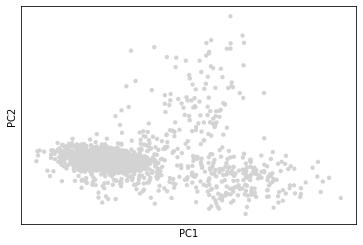

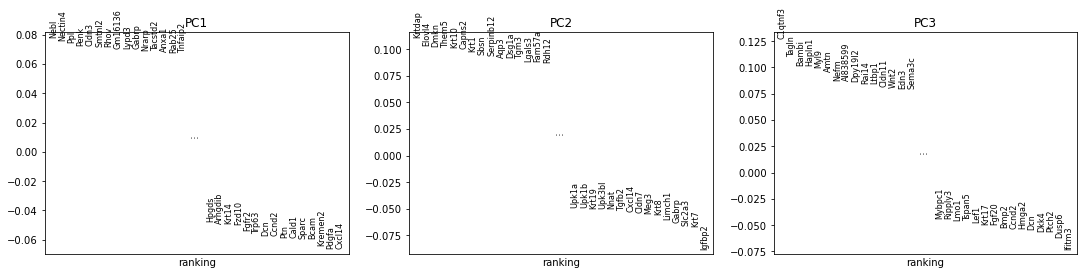

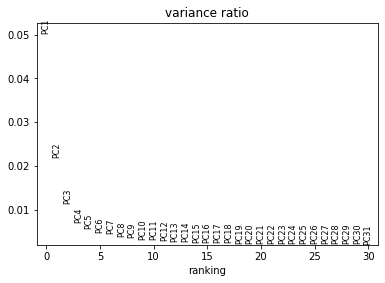

In [32]:
#Run PCA on scaled data from Seurat
sc.pp.pca(adata)
sc.pl.pca_overview(adata)

In [33]:
#Correct for batch effect from sampling date with the help of BBKNN
bbknn.bbknn(adata, batch_key = 'sample_date')

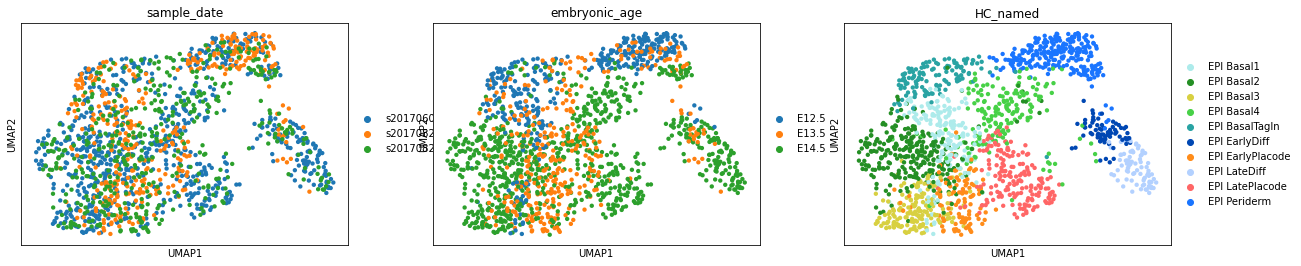

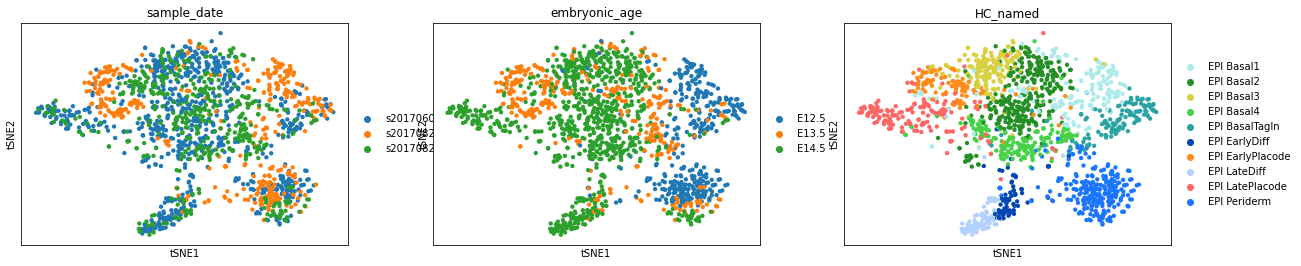

In [34]:
#Run UMAP and tSNE and plot metadata from Seurat onto UMAP
#Note: Additional metadata is available (e.g. read counts, percentage of mitochondrial reads, etc.). Check adata.obs
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['sample_date','embryonic_age', 'HC_named'])
sc.tl.tsne(adata)
sc.pl.tsne(adata, color = ['sample_date','embryonic_age','HC_named'])

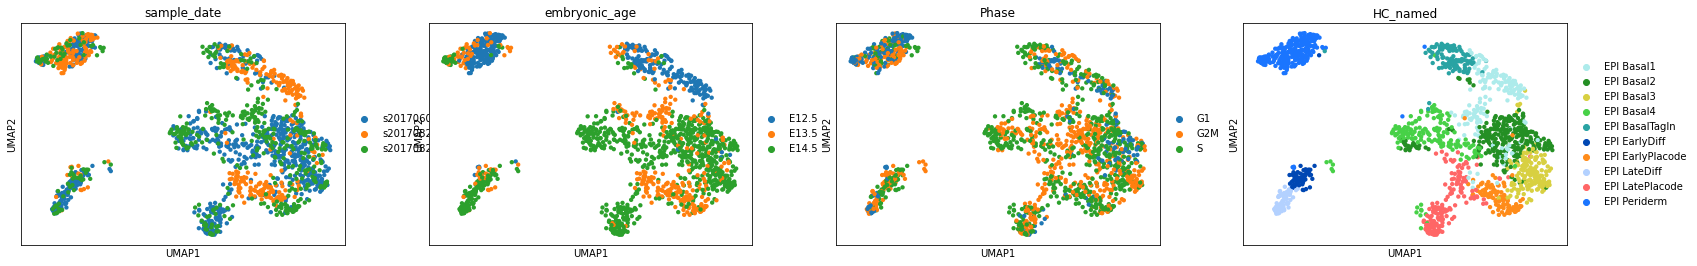

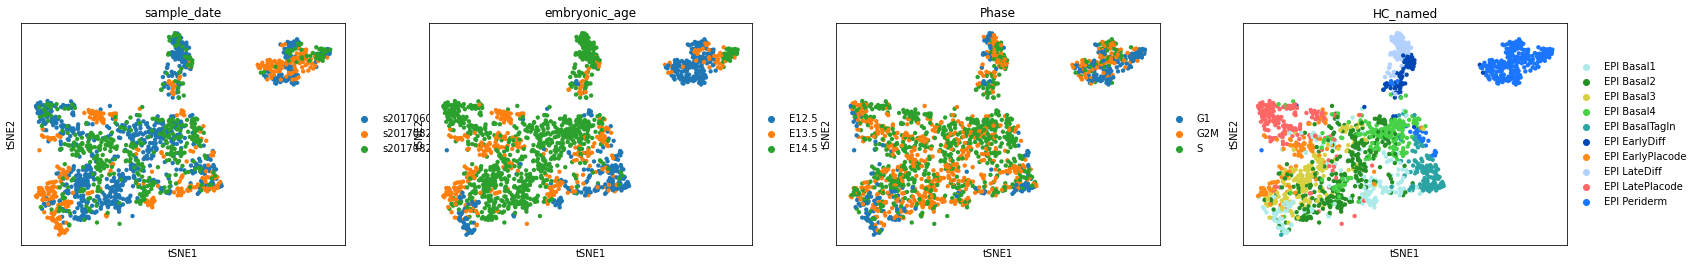

In [35]:
#Replace UMAP and tSNE coordinates from Scanpy with precomputed UMAP and tSNE coordinates from Seurat (R)
adata.obsm['X_umap'] = umap.loc[adata.obs_names].values
adata.obsm['X_tsne'] = tsne.loc[adata.obs_names].values
sc.pl.umap(adata, color = ['sample_date', 'embryonic_age','Phase', 'HC_named'])
sc.pl.tsne(adata, color = ['sample_date', 'embryonic_age', 'Phase','HC_named'])

# Saving

## Save adata object as h5ad file

In [36]:
#h5ad file is provided on Zenodo
adata.write_h5ad(os.path.join(path, 'Notebook-Output', 'Adata-object_{}.h5'.format(cell_type)))

## Save epidermal subclustering results

In [37]:
cluster_df = pd.DataFrame()
cluster_df['2nd_level_Epi'] = adata.obs['HC_named']
cluster_df.to_csv(os.path.join(path, 'Notebook-Output', 'EPI_2nd-level-clustering.txt'))

## Save UMAP coordinates

In [38]:
pd.DataFrame(data = adata.obsm['X_umap'], index = adata.obs_names).to_csv(os.path.join(path, 'Notebook-Output', 'EPI_Umap-coordinates.csv'))

# Plotting

## Figure 7

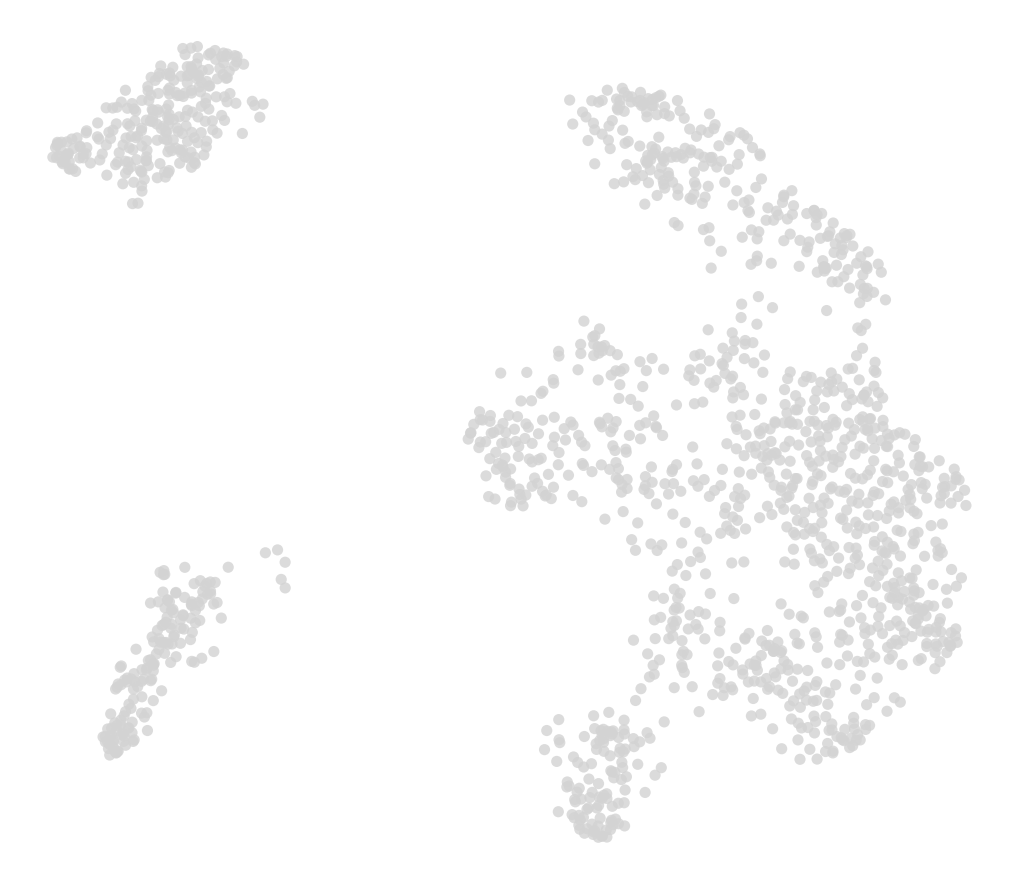

In [39]:
mult = 2
fig, ax = plt.subplots(figsize = (9*mult, 8*mult))
sc.pl.umap(adata, ax = ax, show = False,frameon = False, s = 500, title = '', alpha = 0.8)
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPI_UMAP_AllGray.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

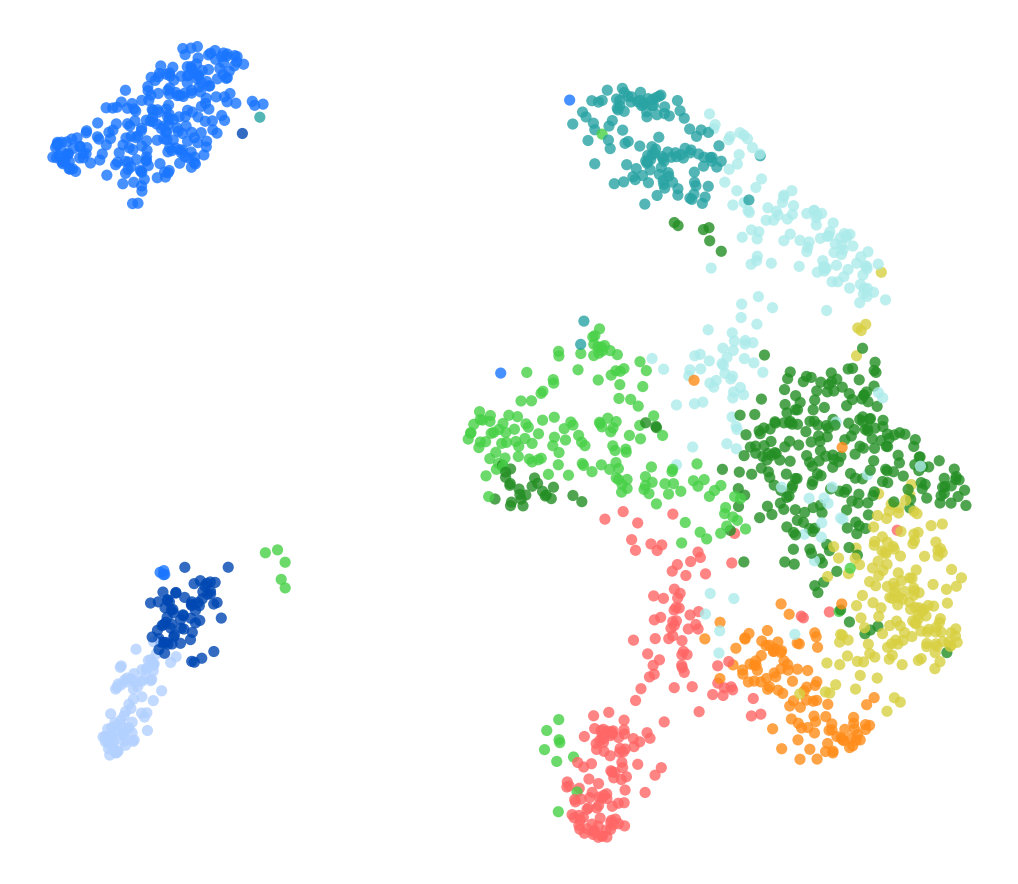

In [40]:
ult = 2
fig, ax = plt.subplots(figsize = (9*mult, 8*mult))
sc.pl.umap(adata, ax = ax, show = False,frameon = False, s = 500, title = '', alpha = 0.8,color='HC_named')
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPI_UMAP_Clustering.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

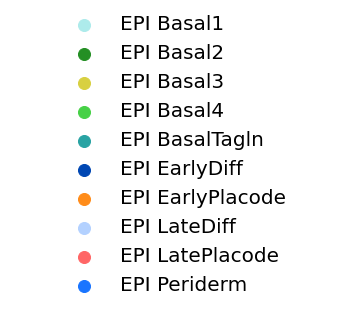

In [41]:
label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":20},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'EPI_UMAP_clusters_legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [42]:
#Assign colors to categorical variable 'embryonic age'
adata.uns['embryonic_age_colors']=['#E00D75','#85C100','#3399C1']

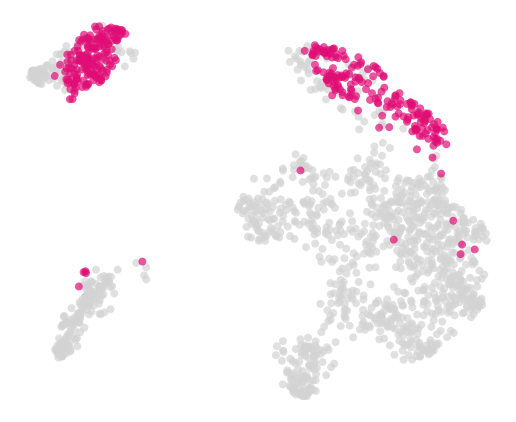

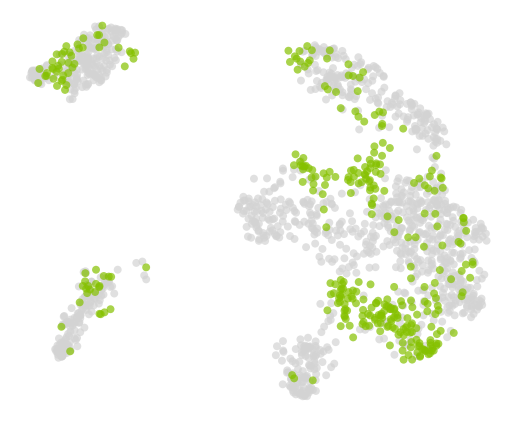

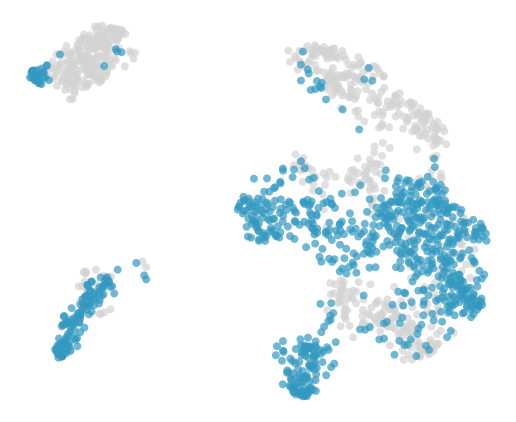

In [43]:
#Only highlight cells sampled at a specific embryonic age in color on top of a grey UMAP showing all epidermal cells
mult = 3
fig, ax = plt.subplots(figsize = (3*mult, 2.5*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 250, title = '', alpha = 0.7,color='embryonic_age', groups=['E12.5'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPI_Age_E12.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

fig, ax = plt.subplots(figsize = (3*mult, 2.5*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 250, title = '', alpha = 0.7,color='embryonic_age', groups=['E13.5'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPI_Age_E13.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

fig, ax = plt.subplots(figsize = (3*mult, 2.5*mult))
sc.pl.umap(adata, ax = ax, show = False, frameon = False, s = 250, title = '', alpha = 0.7,color='embryonic_age', groups=['E14.5'])
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPI_Age_E14.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

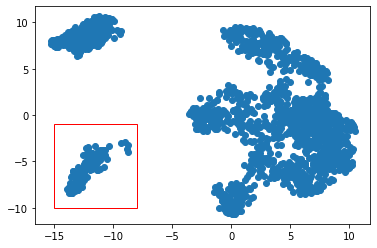

In [44]:
#Subset adata object to differentiated cells for plotting of only these cells
fig, ax = plt.subplots()
x,y = zip(*adata.obsm['X_umap'])
ax.scatter(x,y)
#Specify here which points (x,y) should make up the corners of the polygon
roi_coordinates = np.array([[-15,-10],[-15,-1],[-8,-1],[-8,-10]])
roi = mpl.patches.Polygon(roi_coordinates, fill = False, edgecolor = 'r', )
#Visualize region of interest to double check that the box is made correctly
ax.add_patch(roi)
#Subset to cells within the roi
roi_adata = adata[roi.get_path().contains_points(adata.obsm['X_umap'])]

In [45]:
#Generate color bar for plotting gene expression levels on top of UMAP
colors = [(0.8, 0.8, 0.8), (0.19, 0.04, 0.55)] # first color is grey, last is dark purple
cm = LinearSegmentedColormap.from_list("Custom", colors, N=200)

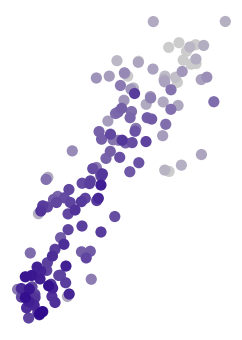

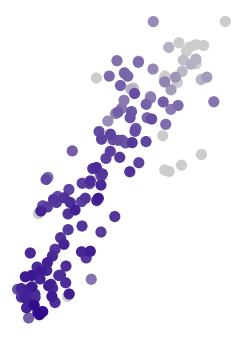

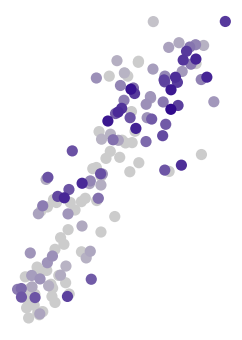

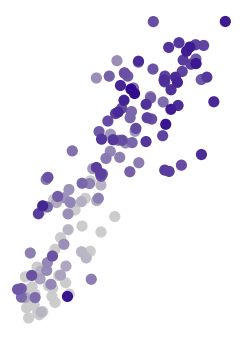

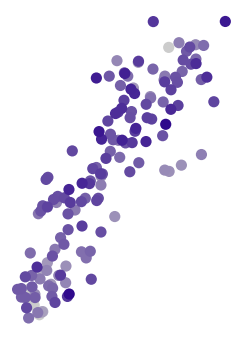

In [46]:
#Plot gene expression on differentiated cells only
genelist=['Krt10','Krtdap','Krt15','Krt14','Krt5']
mult = 3

for gene in genelist:
    fig, ax = plt.subplots(figsize = (1.5*mult, 2*mult))
    sc.pl.umap(roi_adata[roi_adata.obs['HC_named'].isin(['EPI EarlyDiff','EPI LateDiff'])], color =gene, layer='normalized', ax = ax, show = False, frameon = False, s = 500, title = '', alpha = 1, color_map=cm)
    ax.collections[-1].colorbar.remove()
    fig.savefig(os.path.join(path, 'Notebook-Output', 'EPIdiff_Expression_{}.png'.format(gene)), transparent = True, bbox_inches = 'tight', dpi = 100)

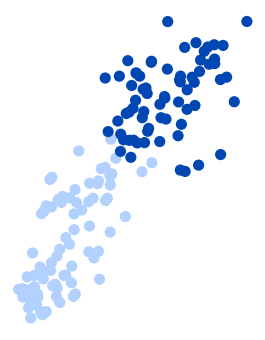

In [47]:
#Plot clustering on differentiated cells only
mult = 3
fig, ax = plt.subplots(figsize = (1.5*mult, 2*mult))
sc.pl.umap(roi_adata[roi_adata.obs['HC_named'].isin(['EPI EarlyDiff','EPI LateDiff'])], color ='HC_named', layer='normalized', ax = ax, show = False, frameon = False, s = 500, title = '', alpha = 1, color_map=cm)
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPIdiff_Clustering.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

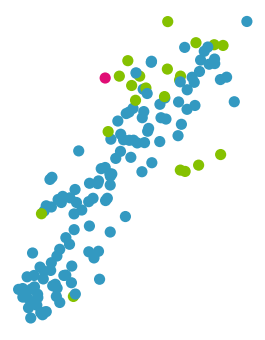

In [48]:
#Plot embryonic age on differentiated cells only
mult = 3
fig, ax = plt.subplots(figsize = (1.5*mult, 2*mult))
sc.pl.umap(roi_adata[roi_adata.obs['HC_named'].isin(['EPI EarlyDiff','EPI LateDiff'])], color ='embryonic_age', layer='normalized', ax = ax, show = False, frameon = False, s = 500, title = '', alpha = 1, color_map=cm)
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPIdiff_Age.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [49]:
#Grouping epidermal subclusters into major epidermis groups for plotting purposes
naming_dict = {'EPI Basal1':'EPI BasalAll', 'EPI Basal2':'EPI BasalAll','EPI Basal3':'EPI BasalAll','EPI Basal4':'EPI BasalAll','EPI Periderm':'EPI Periderm','EPI BasalTagln':'EPI BasalAll','EPI EarlyDiff':'EPI EarlyDiff','EPI LateDiff':'EPI LateDiff','EPI EarlyPlacode':'EPI PlacodeAll','EPI LatePlacode':'EPI PlacodeAll',}
adata.obs['HC_named_grouped'] = [naming_dict[x] for x in adata.obs['HC_named']]
adata.obs['HC_named_grouped'] = adata.obs['HC_named_grouped'].astype('category')

In [50]:
#Display names of grouped epidermal subclusters
adata.obs['HC_named_grouped'].cat.categories

Index(['EPI BasalAll', 'EPI EarlyDiff', 'EPI LateDiff', 'EPI Periderm',
       'EPI PlacodeAll'],
      dtype='object')

In [51]:
#Assign colors of grouped epidermal subclusters
adata.uns['HC_named_grouped_colors'] = ['#4DB834','#0047B3','#B3D1Ff','#1A75FF','#EA411B']

In [52]:
#Grouping epidermal subclusters partially into major epidermis groups for plotting purposes
naming_dict = {'EPI Basal1':'EPI BasalAll', 'EPI Basal2':'EPI BasalAll','EPI Basal3':'EPI BasalAll','EPI Basal4':'EPI BasalAll','EPI Periderm':'EPI Periderm','EPI BasalTagln':'EPI BasalAll','EPI EarlyDiff':'EPI EarlyDiff','EPI LateDiff':'EPI LateDiff','EPI EarlyPlacode':'EPI EarlyPlacode','EPI LatePlacode':'EPI LatePlacode',}
adata.obs['HC_named_partiallygrouped'] = [naming_dict[x] for x in adata.obs['HC_named']]
adata.obs['HC_named_partiallygrouped'] = adata.obs['HC_named_partiallygrouped'].astype('category')

In [53]:
#Display names of partially grouped epidermal subclusters
adata.obs['HC_named_partiallygrouped'].cat.categories

Index(['EPI BasalAll', 'EPI EarlyDiff', 'EPI EarlyPlacode', 'EPI LateDiff',
       'EPI LatePlacode', 'EPI Periderm'],
      dtype='object')

In [54]:
#Assign colors of partially grouped epidermal subclusters
adata.uns['HC_named_partiallygrouped_colors'] = ['#4DB834','#0047B3','#FF8c1A','#B3D1Ff','#FF6666','#1A75FF']

ax = axes[ix]


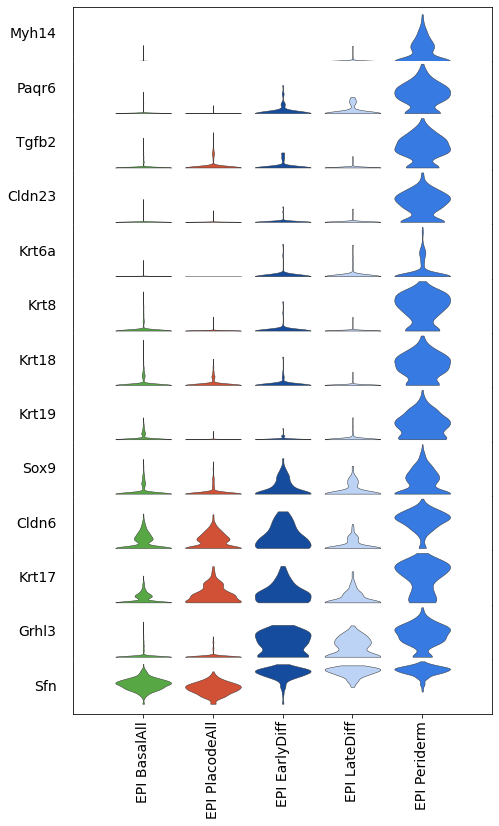

In [55]:
#Generate violin plots with marker genes setting apart the epidermal subclusters
#Note: These plots can be saved with or without labels on x and y axis

#Periderm markers
marker_genes=['Myh14','Paqr6','Tgfb2','Cldn23','Krt6a','Krt8','Krt18','Krt19','Sox9','Cldn6','Krt17','Grhl3','Sfn']
cluster_order = [ 'EPI BasalAll', 'EPI PlacodeAll', 'EPI EarlyDiff', 'EPI LateDiff', 'EPI Periderm']
layer = 'normalized'

ncols = 1
mult=3
fig, axes = initialize_subplots(len(marker_genes), ncols = ncols, figsize_multiplier=(7.5,1), gridspec_kw = {'hspace':0.0})

for ix, gene in enumerate(marker_genes):
    ax = axes[ix]
    sc.pl.violin(adata,keys=gene, groupby = 'HC_named_grouped', cut = 0, ax = ax, show = False, stripplot = False, linewidth = 0.5, layer = layer, order = cluster_order)
   
    if ix == len(marker_genes)-1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 14)
        ax.spines['top'].set_visible(False)
        ax.set_ylim([-1, ax.get_ylim()[1]])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
        if ix == 0:
            ax.spines['bottom'].set_visible(False)
            ax.set_ylim([0, ax.get_ylim()[1] + 0.1*ax.get_ylim()[1]])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    ax.set_ylabel(gene, fontsize = 14, rotation = 0, labelpad = 10, horizontalalignment='right', verticalalignment='center')   #Activate if labels are desired
    #ax.set_ylabel('')            #Comment out if labels are desired
    ax.yaxis.set_ticks_position('none')      

    ax.set_yticklabels([])                                                  #If no min-max values are desired
    #ax.tick_params(axis = 'y', labelsize = 14)                             #To add min-max values on y axis
    #ax.yaxis.set_major_locator(MaxNLocator(integer = True, nbins = 2))     #To add min-max values on y axis
    #ax.set_yticks([x for x in ax.get_yticks() if x>0][:1])                 #To add min-max values on y axis
    
    ax.set_xlabel('')
    ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1]+0.5)
    #ax.set_xticklabels([])        #Comment out if labels are desired
    
fig.savefig(os.path.join(path, 'Notebook-Output', 'Epi_Vln_Periderm_WithXLabels.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

ax = axes[ix]


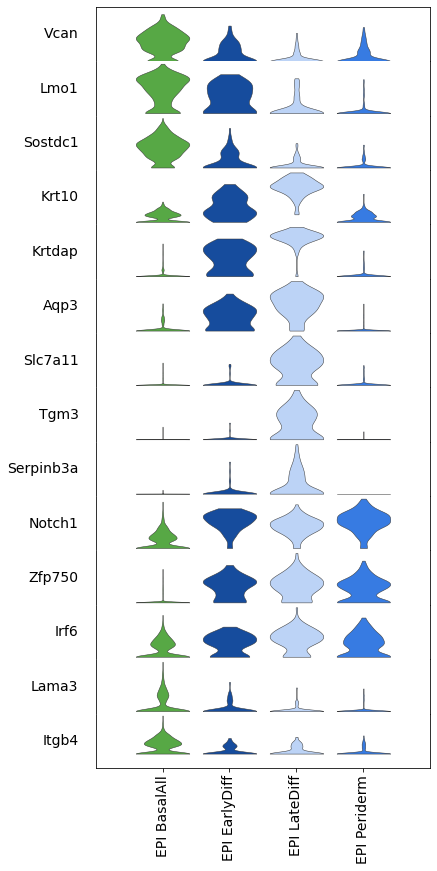

In [56]:
#Generate violin plots with marker genes setting apart the epidermal subclusters
#Note: These plots can be saved with or without labels on x and y axis

#Differentiation markers
marker_genes=['Vcan','Lmo1','Sostdc1','Krt10','Krtdap','Aqp3','Slc7a11','Tgm3','Serpinb3a','Notch1','Zfp750','Irf6','Lama3','Itgb4']
cluster_order = [ 'EPI BasalAll', 'EPI EarlyDiff', 'EPI LateDiff', 'EPI Periderm']
layer = 'normalized'

ncols = 1
mult=1
fig, axes = initialize_subplots(len(marker_genes), ncols = ncols, figsize_multiplier=(6*mult,1*mult), gridspec_kw = {'hspace':0.0})

for ix, gene in enumerate(marker_genes):
    ax = axes[ix]
    sc.pl.violin(adata,keys=gene, groupby = 'HC_named_grouped', cut = 0, ax = ax, show = False, stripplot = False, linewidth = 0.5, layer = layer, order = cluster_order)
   
    if ix == len(marker_genes)-1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 14)
        ax.spines['top'].set_visible(False)
        ax.set_ylim([-1, ax.get_ylim()[1]])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
        if ix == 0:
            ax.spines['bottom'].set_visible(False)
            ax.set_ylim([0, ax.get_ylim()[1] + 0.1*ax.get_ylim()[1]])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    ax.set_ylabel(gene, fontsize = 14, rotation = 0, labelpad = 10, horizontalalignment='right', verticalalignment='center')   #Activate if labels are desired
    #ax.set_ylabel('')            #Comment out if labels are desired
    ax.yaxis.set_ticks_position('none')      

    ax.set_yticklabels([])                                                  #If no min-max values are desired
    #ax.tick_params(axis = 'y', labelsize = 14)                             #To add min-max values on y axis
    #ax.yaxis.set_major_locator(MaxNLocator(integer = True, nbins = 2))     #To add min-max values on y axis
    #ax.set_yticks([x for x in ax.get_yticks() if x>0][:1])                 #To add min-max values on y axis
    
    ax.set_xlabel('')
    ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1]+0.5)
    #ax.set_xticklabels([])        #Comment out if labels are desired    
    
fig.savefig(os.path.join(path, 'Notebook-Output', 'Epi_Vln_Differentiation_WithLabels.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

ax = axes[ix]


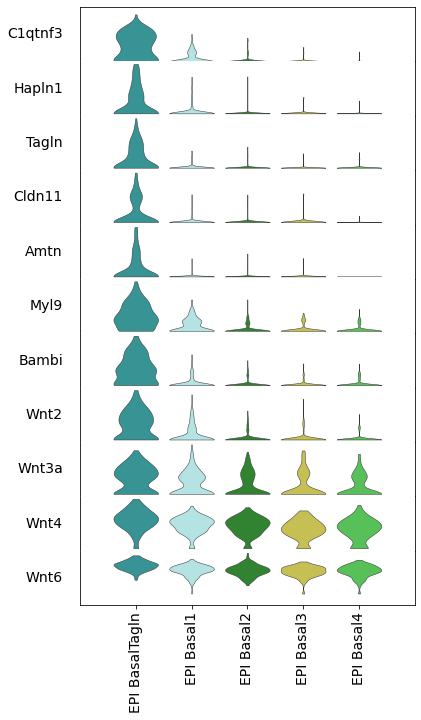

In [57]:
#Generate violin plots with marker genes setting apart the epidermal subclusters
#Note: These plots can be saved with or without labels on x and y axis

#BasalTagln markers
marker_genes=['C1qtnf3','Hapln1','Tagln','Cldn11','Amtn','Myl9','Bambi','Wnt2','Wnt3a','Wnt4','Wnt6']
cluster_order = [ 'EPI BasalTagln', 'EPI Basal1', 'EPI Basal2', 'EPI Basal3', 'EPI Basal4']
layer = 'normalized'

ncols = 1
mult=1
fig, axes = initialize_subplots(len(marker_genes), ncols = ncols, figsize_multiplier=(6*mult,1*mult), gridspec_kw = {'hspace':0.0})

for ix, gene in enumerate(marker_genes):
    ax = axes[ix]
    sc.pl.violin(adata,keys=gene, groupby = 'HC_named', cut = 0, ax = ax, show = False, stripplot = False, linewidth = 0.5, layer = layer, order = cluster_order)
   
    if ix == len(marker_genes)-1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 14)
        ax.spines['top'].set_visible(False)
        ax.set_ylim([-1, ax.get_ylim()[1]])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
        if ix == 0:
            ax.spines['bottom'].set_visible(False)
            ax.set_ylim([0, ax.get_ylim()[1] + 0.1*ax.get_ylim()[1]])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    ax.set_ylabel(gene, fontsize = 14, rotation = 0, labelpad = 10, horizontalalignment='right', verticalalignment='center')   #Activate if labels are desired
    #ax.set_ylabel('')            #Comment out if labels are desired
    ax.yaxis.set_ticks_position('none')      

    ax.set_yticklabels([])                                                  #If no min-max values are desired
    #ax.tick_params(axis = 'y', labelsize = 14)                             #To add min-max values on y axis
    #ax.yaxis.set_major_locator(MaxNLocator(integer = True, nbins = 2))     #To add min-max values on y axis
    #ax.set_yticks([x for x in ax.get_yticks() if x>0][:1])                 #To add min-max values on y axis
    
    ax.set_xlabel('')
    ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1]+0.5)
    #ax.set_xticklabels([])        #Comment out if labels are desired    
    
fig.savefig(os.path.join(path, 'Notebook-Output', 'Epi_Vln_Tagln_WithLabels.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

ax = axes[ix]


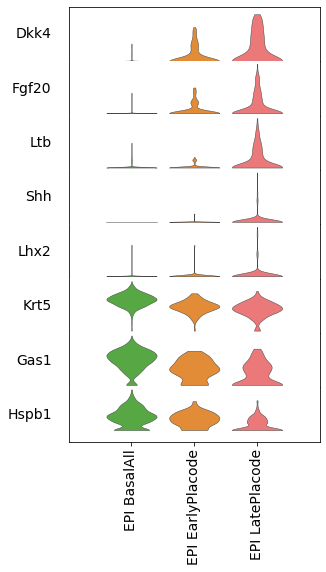

In [58]:
#Generate violin plots with marker genes setting apart the epidermal subclusters
#Note: These plots can be saved with or without labels on x and y axis

#Placode markers
marker_genes=['Dkk4','Fgf20','Ltb','Shh','Lhx2','Krt5','Gas1','Hspb1']
cluster_order = [ 'EPI BasalAll', 'EPI EarlyPlacode','EPI LatePlacode']
layer = 'normalized'

ncols = 1
mult=1
fig, axes = initialize_subplots(len(marker_genes), ncols = ncols, figsize_multiplier=(4.5*mult,1*mult), gridspec_kw = {'hspace':0.0})

for ix, gene in enumerate(marker_genes):
    ax = axes[ix]
    sc.pl.violin(adata,keys=gene, groupby = 'HC_named_partiallygrouped', cut = 0, ax = ax, show = False, stripplot = False, linewidth = 0.5, layer = layer, order = cluster_order)
   
    if ix == len(marker_genes)-1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 14)
        ax.spines['top'].set_visible(False)
        ax.set_ylim([-1, ax.get_ylim()[1]])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
        if ix == 0:
            ax.spines['bottom'].set_visible(False)
            ax.set_ylim([0, ax.get_ylim()[1] + 0.1*ax.get_ylim()[1]])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    ax.set_ylabel(gene, fontsize = 14, rotation = 0, labelpad = 10, horizontalalignment='right', verticalalignment='center')   #Activate if labels are desired
    #ax.set_ylabel('')            #Comment out if labels are desired
    ax.yaxis.set_ticks_position('none')      

    ax.set_yticklabels([])                                                  #If no min-max values are desired
    #ax.tick_params(axis = 'y', labelsize = 14)                             #To add min-max values on y axis
    #ax.yaxis.set_major_locator(MaxNLocator(integer = True, nbins = 2))     #To add min-max values on y axis
    #ax.set_yticks([x for x in ax.get_yticks() if x>0][:1])                 #To add min-max values on y axis
    
    ax.set_xlabel('')
    ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1]+0.5)
    #ax.set_xticklabels([])        #Comment out if labels are desired
    
fig.savefig(os.path.join(path, 'Notebook-Output', 'Epi_Vln_Placode_WithLabels.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

## Figure S6

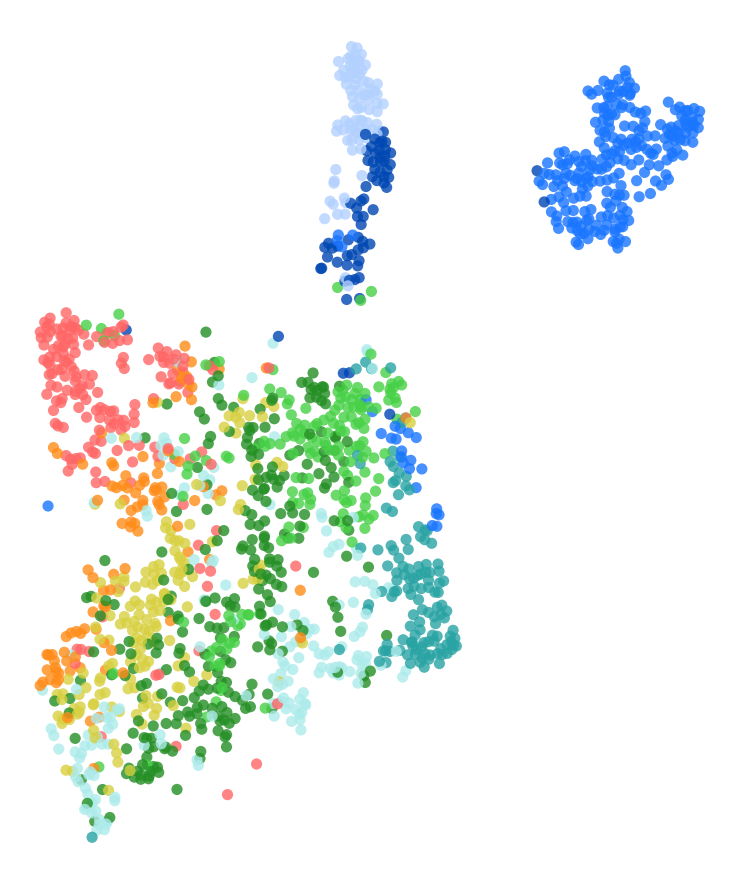

In [59]:
mult = 2
fig, ax = plt.subplots(figsize = (6.5*mult, 8*mult))
sc.pl.tsne(adata, ax = ax, show = False, color='HC_named',frameon = False, s = 500, title = '', alpha = 0.8)
ax.legend().remove()
fig.savefig(os.path.join(path, 'Notebook-Output', 'Epi_Tsne_Clustering.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

ax = axes[ix]


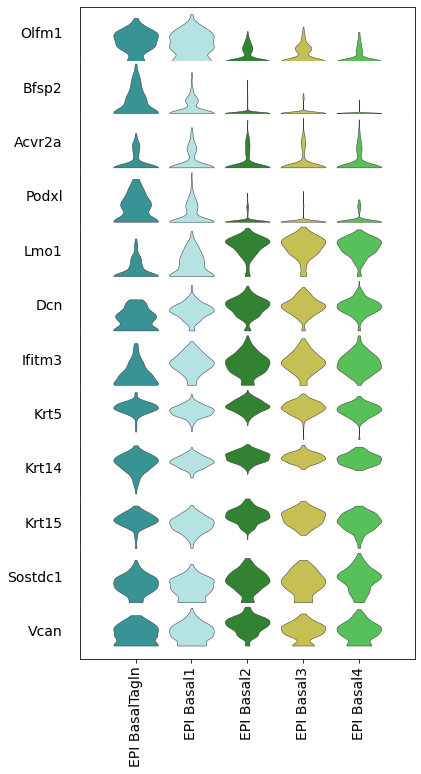

In [60]:
#Generate violin plots with marker genes setting apart the epidermal subclusters
#Note: These plots can be saved with or without labels on x and y axis

#Basal markers
marker_genes=['Olfm1','Bfsp2','Acvr2a','Podxl','Lmo1','Dcn','Ifitm3','Krt5','Krt14','Krt15','Sostdc1','Vcan']
cluster_order = [ 'EPI BasalTagln', 'EPI Basal1', 'EPI Basal2', 'EPI Basal3', 'EPI Basal4']
layer = 'normalized'

ncols = 1
mult=1
fig, axes = initialize_subplots(len(marker_genes), ncols = ncols, figsize_multiplier=(6*mult,1*mult), gridspec_kw = {'hspace':0.0})

for ix, gene in enumerate(marker_genes):
    ax = axes[ix]
    sc.pl.violin(adata,keys=gene, groupby = 'HC_named', cut = 0, ax = ax, show = False, stripplot = False, linewidth = 0.5, layer = layer, order = cluster_order)
   
    if ix == len(marker_genes)-1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 14)
        ax.spines['top'].set_visible(False)
        ax.set_ylim([-1, ax.get_ylim()[1]])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
        if ix == 0:
            ax.spines['bottom'].set_visible(False)
            ax.set_ylim([0, ax.get_ylim()[1] + 0.1*ax.get_ylim()[1]])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    ax.set_ylabel(gene, fontsize = 14, rotation = 0, labelpad = 10, horizontalalignment='right', verticalalignment='center')   #Activate if labels are desired
    #ax.set_ylabel('')            #Comment out if labels are desired
    ax.yaxis.set_ticks_position('none')      

    ax.set_yticklabels([])                                                  #If no min-max values are desired
    #ax.tick_params(axis = 'y', labelsize = 14)                             #To add min-max values on y axis
    #ax.yaxis.set_major_locator(MaxNLocator(integer = True, nbins = 2))     #To add min-max values on y axis
    #ax.set_yticks([x for x in ax.get_yticks() if x>0][:1])                 #To add min-max values on y axis
    
    ax.set_xlabel('')
    ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1]+0.5)
    #ax.set_xticklabels([])        #Comment out if labels are desired    
    
fig.savefig(os.path.join(path, 'Notebook-Output', 'Epi_Vln_Tagln_WithLabels.pdf'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [61]:
## Calculate age distribution
age_dist = adata.obs[['embryonic_age', 'HC_named']]
age_dist = pd.DataFrame(age_dist.groupby(by = 'HC_named')['embryonic_age'].value_counts().div(age_dist.groupby(by = 'HC_named')['embryonic_age'].count()))
age_dist.columns = ['Fraction']
age_dist = age_dist.reset_index()
age_dist = age_dist.pivot(index = 'HC_named', columns = 'embryonic_age', values = 'Fraction')
age_dist = age_dist.sort_values(by=['E12.5','E13.5'],ascending=False)
age_dist

embryonic_age,E12.5,E13.5,E14.5
HC_named,,,
EPI BasalTagln,0.696721,0.196721,0.106557
EPI Periderm,0.680000,0.176000,0.144000
EPI Basal1,0.543860,0.345029,0.111111
EPI Basal3,0.030864,0.166667,0.802469
EPI EarlyDiff,0.014493,0.289855,0.695652
EPI Basal2,0.014134,0.077739,0.908127
EPI Basal4,0.011696,0.134503,0.853801
EPI EarlyPlacode,NaN,0.826923,0.173077
EPI LatePlacode,NaN,0.232558,0.767442


In [62]:
#Set order for plotting epidermal subclusters
order = ['EPI BasalTagln','EPI Basal1','EPI Basal2','EPI Basal3','EPI Basal4','EPI EarlyPlacode','EPI LatePlacode','EPI EarlyDiff','EPI LateDiff','EPI Periderm']
age_dist = age_dist.loc[order]

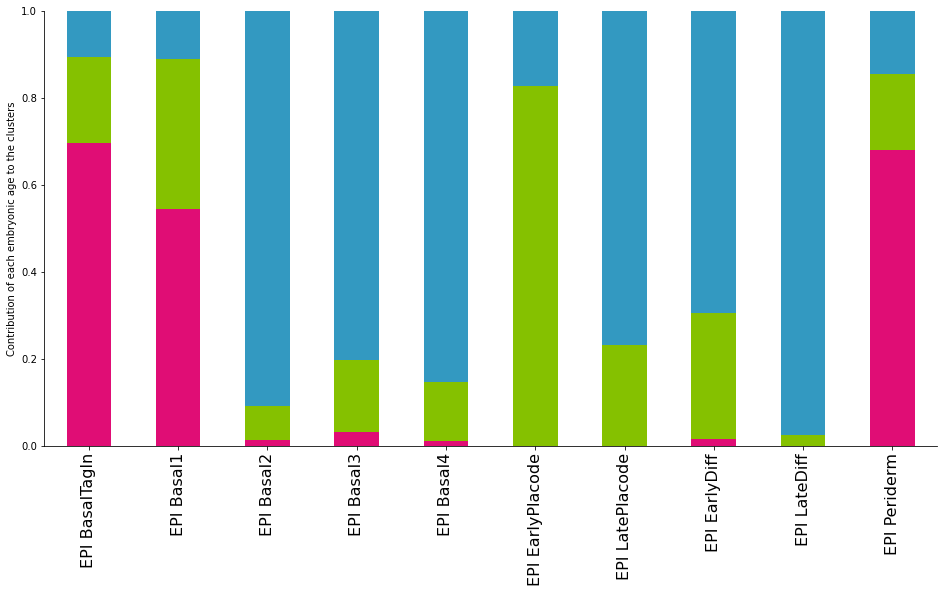

In [63]:
#Plot age distribution of epidermal subclusters (how many cells of each cell type originate from which embryonic age?)
#Note: These plots can be saved with or without labels on x and y axis
cmap = {'E12.5': '#E00D75',
        'E13.5': '#85C100',
        'E14.5': '#3399C1'}

mult=2
fig, ax = plt.subplots(figsize = (8*mult, 4*mult))
age_dist.plot.bar(stacked = True, ax = ax, color = cmap.values())
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize = 16, rotation = 90)  #Comment out if no labels are desired
ax.set_ylabel('Contribution of each embryonic age to the clusters')    #Comment out if no labels are desired
#ax.set_xticklabels([])    #Activate if no labels are desired
#ax.set_yticklabels([])    #Activate if no labels are desired
clear_output()
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPI_Age-Contribution_WithLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

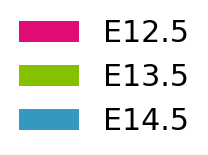

In [64]:
#Plot legend for barplots of age distribution
label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots(figsize = (2, 2))
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":30},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'EPI_Age-Contribution_Legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [65]:
## Calculate cell cycle distribution
cc_dist = adata.obs[['Phase', 'HC_named']]
cc_dist = pd.DataFrame(cc_dist.groupby(by = 'HC_named')['Phase'].value_counts().div(cc_dist.groupby(by = 'HC_named')['Phase'].count()))
cc_dist.columns = ['Fraction']
cc_dist = cc_dist.reset_index()
cc_dist = cc_dist.pivot(index = 'HC_named', columns = 'Phase', values = 'Fraction')
cc_dist = cc_dist.sort_values(by=['G1','G2M'],ascending=False)
cc_dist

Phase,G1,G2M,S
HC_named,,,
EPI Periderm,0.480000,0.328000,0.192000
EPI LateDiff,0.312500,0.400000,0.287500
EPI BasalTagln,0.237705,0.278689,0.483607
EPI Basal1,0.216374,0.362573,0.421053
EPI Basal3,0.141975,0.469136,0.388889
EPI Basal2,0.102473,0.388693,0.508834
EPI LatePlacode,0.075581,0.470930,0.453488
EPI EarlyPlacode,0.048077,0.326923,0.625000
EPI EarlyDiff,0.014493,0.434783,0.550725


In [66]:
#Set order for plotting epidermal subclusters
order = ['EPI BasalTagln','EPI Basal1','EPI Basal2','EPI Basal3','EPI Basal4','EPI EarlyPlacode','EPI LatePlacode','EPI EarlyDiff','EPI LateDiff','EPI Periderm']
cc_dist = cc_dist.loc[order]

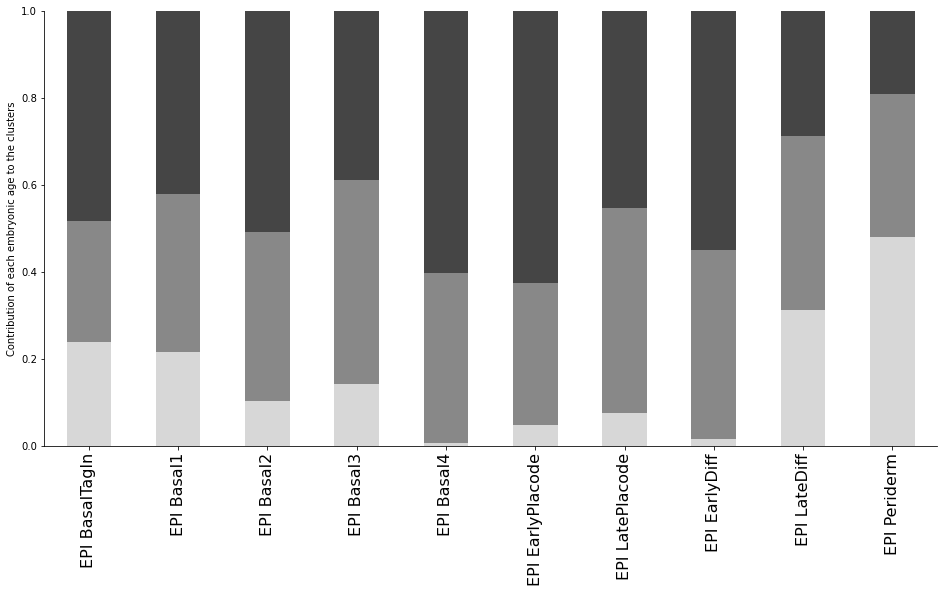

In [67]:
#Plot age distribution of the fibroblast subclusters (how many cells of each subcluster are in which cell cycle phase?)
#Note: This plot can be saved with or without labels on x and y axis
cmap = {'G1': '#D7D7D7',
        'G2M': '#888888',
        'S': '#454545'}

mult=2
fig, ax = plt.subplots(figsize = (8*mult, 4*mult))
cc_dist.plot.bar(stacked = True, ax = ax, color = cmap.values())
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize = 16, rotation = 90)  #Comment out if no labels are desired
ax.set_ylabel('Contribution of each embryonic age to the clusters')    #Comment out if no labels are desired
#ax.set_xticklabels([])    #Activate if no labels are desired
#ax.set_yticklabels([])    #Activate if no labels are desired
clear_output()
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPI_CellCycle-Contribution_WithLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

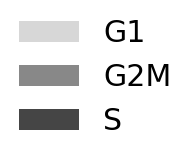

In [68]:
#Plot legend for barplots of cell cycle distribution
label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots(figsize = (2, 2))
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":30},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'EPI_CellCycle-Contribution_Legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

In [69]:
#Read in pre-computed table with number of ligands and receptors among marker genes for each subcluster 
df = pd.read_excel(os.path.join(path, 'Notebook-Input','Number_ExpressedReceptorsAndLigands.xlsx'), index_col = 0, engine = 'openpyxl',sheet_name='EPI')
df = df.reset_index()
df = df.melt(id_vars = ['index'], value_vars = ['ligands','receptors'])
df

,index,variable,value
0,EPI BasalTagln,ligands,34
1,EPI Basal1,ligands,12
2,EPI Basal2,ligands,6
3,EPI Basal3,ligands,1
4,EPI Basal4,ligands,3
5,EPI EarlyPlacode,ligands,11
6,EPI LatePlacode,ligands,14
7,EPI EarlyDiff,ligands,6
8,EPI LateDiff,ligands,20
9,EPI Periderm,ligands,35


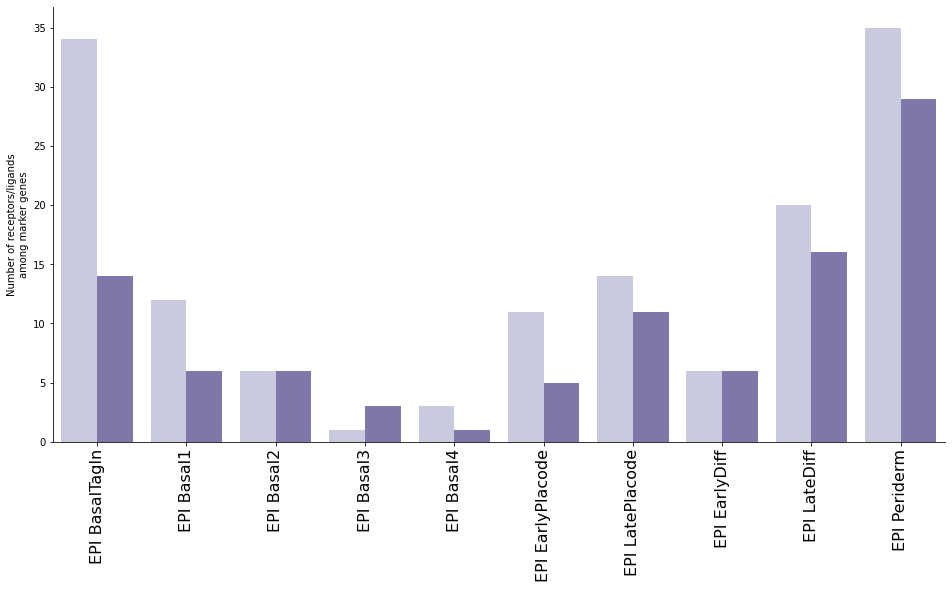

In [70]:
#Plot number of receptors/ligands per subcluster
#Note: This plot can be saved with or without labels on x and y axis
mult=2
fig, ax = plt.subplots(figsize = (8*mult, 4*mult))
sbn.barplot(data = df, x = 'index', y = 'value', hue = 'variable', ax = ax, palette = 'Purples')
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize = 16, rotation = 90)  
ax.set_xlabel('')
ax.set_ylabel('Number of receptors/ligands\namong marker genes')     #Comment Out if no labels are desired
[ax.spines[side].set_visible(False) for side in ['top','right']]

#ax.set_ylabel('')            #Activate if no labels are desired
#ax.set_xticklabels([])    #Activate if no labels are desired
#ax.set_yticklabels([])    #Activate if no labels are desired
clear_output()
fig.savefig(os.path.join(path, 'Notebook-Output', 'EPI_NumberReceptorLigand_WithLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

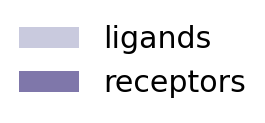

In [71]:
#Plot legend for barplots of ligands/receptors
label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots(figsize = (2, 2))
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":30},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'EPI_NumberReceptorLigand_Legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

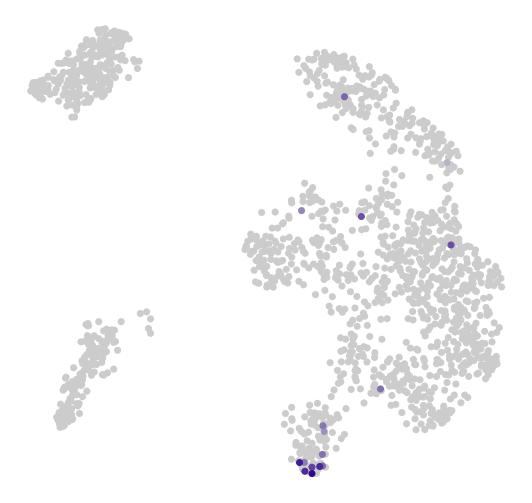

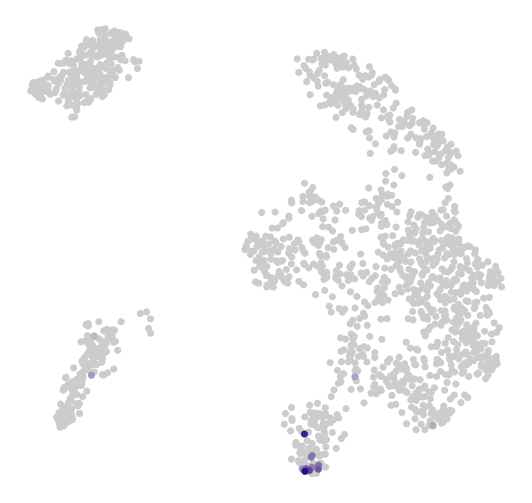

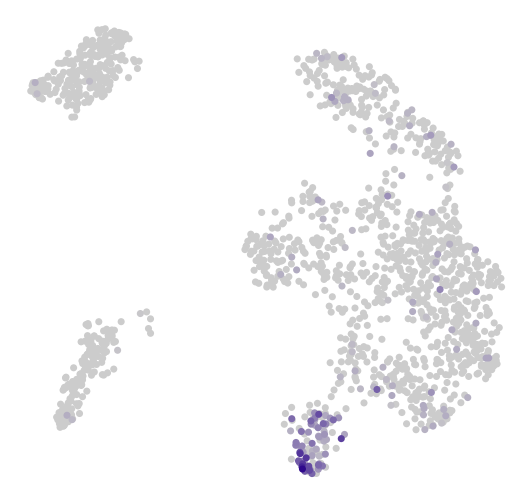

In [72]:
#Plot gene expression on all epidermal cells
genelist=['Lhx2','Shh','Ltb']
mult = 3

for gene in genelist:
    fig, ax = plt.subplots(figsize = (3.4*mult, 3*mult))
    sc.pl.umap(adata, color =gene, layer='normalized', ax = ax, show = False, frameon = False, s = 200, title = '', alpha = 1, color_map=cm)
    ax.collections[-1].colorbar.remove()
    fig.savefig(os.path.join(path, 'Notebook-Output', 'EPI_Expression_{}.png'.format(gene)), transparent = True, bbox_inches = 'tight', dpi = 100)

In [73]:
#Generate color bar for plotting gene expression levels in DotPlot
colors = [(1,1,1), (0.19, 0.04, 0.55)] # first color is white, last is dark purple
cm = LinearSegmentedColormap.from_list("Custom", colors, N=200)

{'mainplot_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

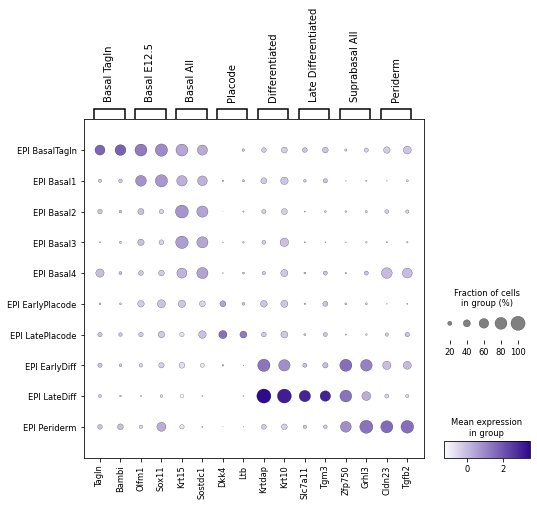

In [74]:
#Optional: DotPlot of epidermal subclusters
marker_genes_dict = {'Basal Tagln': ['Tagln','Bambi'],
                      'Basal E12.5': ['Olfm1','Sox11'],
                    'Basal All': ['Krt15','Sostdc1'],
                     'Placode': ['Dkk4','Ltb'],
                     'Differentiated': ['Krtdap','Krt10'],
                     'Late Differentiated': ['Slc7a11','Tgm3'],
                    'Suprabasal All': ['Zfp750','Grhl3'],
                     'Periderm': ['Cldn23','Tgfb2']}
order=['EPI BasalTagln','EPI Basal1','EPI Basal2','EPI Basal3','EPI Basal4','EPI EarlyPlacode','EPI LatePlacode','EPI EarlyDiff','EPI LateDiff','EPI Periderm']

mult=2
fig, ax = plt.subplots(figsize=(4*mult,4*mult))
sc.pl.dotplot(adata, marker_genes_dict, groupby='HC_named',dendrogram=False, ax=ax,show=False,cmap=cm,categories_order=order)